In [1]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)
from jax import grad, random, jit, vmap
from functools import partial
import jax.example_libraries.optimizers as optimizers
import pickle
key = random.PRNGKey(0)
import pandas as pd

from utils import uniaxial_relax, sigma_split_vmap, sigma_neoHook_vmap, init_params_nobias, init_params_positivebias, dPhi_gov_vmap, dPhi_vmap, plot45

In [2]:
# Functions for training
@partial(jit, static_argnums=(0,1,2,))
def step(loss_fn, norm, useNODE, i, opt_state, inp_batch, out_batch):
    params = get_params(opt_state)
    g = grad(loss_fn, argnums=0)(params, norm, useNODE, inp_batch, out_batch)
    return opt_update(i, g, opt_state)

def train(inp, out, norm, useNODE, opt_state, key, loss_fn, nIter = 1000, batch_size=10, print_freq=100):
    train_loss = []
    val_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        i = random.choice(subkey, inp.shape[0], shape=(batch_size,), replace = False)
        i = tuple([i])
        opt_state = step(loss_fn, norm, useNODE, it, opt_state, inp[i], out[i])
        if it % print_freq == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = loss_fn(params, norm, useNODE, inp, out)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss 


# Define loss functions
def uniaxial_relax_loss(params, norm, useNODE, inp, out):
    sigma_pr,_,_,_,_,_,_ = uniaxial_relax(params, norm, useNODE, inp[0], inp[1], dt0=0.1)
    loss = np.mean((-sigma_pr[:,0,0]-out)**2)# + (sigma_pr[:,1,1]-out[1])**2)
    return loss
uniaxial_relax_loss_vmap = vmap(uniaxial_relax_loss, in_axes=(None, None, None, 0, 0), out_axes=0)
uniaxial_relax_batch_loss = lambda params, norm, useNODE, inp, out: np.mean(uniaxial_relax_loss_vmap(params, norm, useNODE, inp, out))

def Psi_loss(params, norm, useNODE, lmb, sigma_gt):
    lm1 = lmb[:,0]
    lm2 = lmb[:,1]
    lm3 = lmb[:,2]
    sigma_pr = sigma_split_vmap(lm1, lm2, lm3, params)
    loss1 = np.mean((sigma_pr[:,0,0]-sigma_gt[:,0,0])**2) 
    loss2 = np.mean((sigma_pr[:,1,1]-sigma_gt[:,1,1])**2)
    loss3 = np.mean((sigma_pr[:,2,2]-sigma_gt[:,2,2])**2)
    loss = (loss1+loss2+loss3)/3
    return  loss

def Phi_loss(params, norm, useNODE, taui, dphidtaui_gt):
    tau1, tau2, tau3 = taui.transpose()
    dphidtaui_pr = dPhi_vmap([tau1, tau2, tau3], params, norm)
    loss = np.mean((dphidtaui_pr[0]-dphidtaui_gt[:,0])**2)
    loss+= np.mean((dphidtaui_pr[1]-dphidtaui_gt[:,1])**2)
    loss+= np.mean((dphidtaui_pr[2]-dphidtaui_gt[:,2])**2)
    return loss

# 1. Train Govindjee's model

In [3]:
with open('training_data/Brain/Average/C1/Comp relaxation/BG.npy','rb') as f:
    time_2, sgm_x_2 = np.load(f).T
time_2 = time_2[::2]
sgm_x_2 = sgm_x_2[::2]

load_rate = 0.03 #loading rate
lm_peak = 0.9
lm_1 = np.linspace(1.0,0.9,10)
lm_2 = np.ones_like(time_2)*lm_peak
lmb_x = np.hstack([lm_1,lm_2])

t_peak = (1.0-lm_peak)/load_rate
print('Reach peak in '+str(t_peak)+' s')
time_1 = np.linspace(0,t_peak,lm_1.shape[0])
time = np.hstack([time_1, time_2+t_peak])

sgm_x_1 = np.linspace(0,sgm_x_2[0],lm_1.shape[0])
sgm_x = np.hstack([sgm_x_1, sgm_x_2])

time = np.expand_dims(time,0)
lmb_x = np.expand_dims(lmb_x,0)
sgm_x = np.expand_dims(sgm_x,0)

inp = np.array([time, lmb_x]).transpose([1,0,2])
out = sgm_x

Reach peak in 3.3333333333333326 s


In [5]:
# Neo Hookean:
mu = 77.77*0.1
K = 1.0
gov_Psi_eq_params = [K, mu]
gov_Psi_neq_params = [K, mu]

eta_D = 1360.0
eta_V = 175000.0
gov_Phi_params = [np.log(eta_D*0.1), np.log(eta_V*0.1)]

gov_params = [gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params]
gov_norm = (None, None, None)

with open('saved/brain_BG_gov_params0.npy', 'rb') as f: #initial guess
    gov_params = pickle.load(f)

In [6]:
lr = 5.0e-4
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(gov_params)
gov_params, train_loss, val_loss = train(inp, out, gov_norm, False, opt_state, key, uniaxial_relax_batch_loss, nIter = 12000, batch_size=1, print_freq=1000)
    
with open('saved/brain_BG_gov_params.npy', 'wb') as f:
    pickle.dump(gov_params, f)

it 0, train loss = 6.497090e-03
it 1000, train loss = 4.292261e-04
it 2000, train loss = 3.278141e-04
it 3000, train loss = 2.959964e-04
it 4000, train loss = 2.918921e-04
it 5000, train loss = 2.907878e-04
it 6000, train loss = 2.892780e-04
it 7000, train loss = 2.873060e-04
it 8000, train loss = 2.770640e-04
it 9000, train loss = 2.699611e-04
it 10000, train loss = 2.402028e-04
it 11000, train loss = 1.812935e-04
it 12000, train loss = 9.694184e-05


[Text(0.5, 1.0, 't_peak = 3.0, loss =0.0001')]

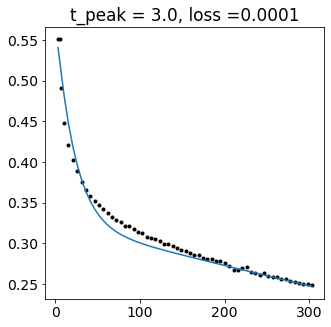

In [7]:
fig, ax = plt.subplots(figsize=[5,5])
sigm_pr,lm1,lm2,lm3,lm1e,lm2e,lm3e = uniaxial_relax(gov_params, gov_norm, False, time[0], lmb_x[0], dt0=0.1)

ax.plot(time[0,9:],out[0,9:],'k.')
ax.plot(time[0,9:],-sigm_pr[9:,0,0])
ax.set(title='t_peak = ' + str(np.round(t_peak)) + ', loss =' + str(np.round(train_loss[-1],5)))

# 2. Train $\Psi_{EQ}$ and $\Psi_{NEQ}$

In [8]:
with open('saved/brain_BG_gov_params.npy', 'rb') as f:
    gov_params = pickle.load(f)
gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params = gov_params

In [9]:
# Generate training data
# Inputs
lm = np.linspace(0.85,1.1,20)
lm1, lm2 = np.array(np.meshgrid(lm, lm))
lm1 = lm1.reshape(-1)
lm2 = lm2.reshape(-1)
lm3 = 1/(lm1*lm2)
lmb_1 = np.transpose(np.array([lm1, lm2, lm3]))
lmb_2 = np.transpose(np.array([lm1, lm2, lm3*0.95]))
lmb = np.vstack([lmb_1, lmb_2])

# Outputs
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],gov_Psi_eq_params)

## 2.1 $\Psi_{EQ}$

In [10]:
# Initialize parameters
layers = [1, 5, 5, 1]
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
K, mu = gov_Psi_eq_params
Psi_eq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias, K)
Psi_eq_norm = None

# Train
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Psi_eq_params)
Psi_eq_params, train_loss, val_loss = train(lmb, sigma_gt, Psi_eq_norm, False, opt_state, key, Psi_loss, nIter = 200000, batch_size=10, print_freq=10000)
with open('saved/brain_BG_Psi_eq_params.npy', 'wb') as f:
    pickle.dump(Psi_eq_params, f)

it 0, train loss = 1.501483e+01
it 10000, train loss = 5.084937e-03
it 20000, train loss = 1.963629e-03
it 30000, train loss = 2.928812e-04
it 40000, train loss = 1.279675e-04
it 50000, train loss = 7.942008e-05
it 60000, train loss = 4.588232e-05
it 70000, train loss = 2.567305e-05
it 80000, train loss = 1.355735e-05
it 90000, train loss = 7.153199e-06
it 100000, train loss = 3.671507e-06
it 110000, train loss = 1.870942e-06
it 120000, train loss = 1.068731e-06
it 130000, train loss = 4.716572e-07
it 140000, train loss = 2.406006e-07
it 150000, train loss = 1.426947e-07
it 160000, train loss = 6.103304e-08
it 170000, train loss = 3.503553e-08
it 180000, train loss = 6.429359e-08
it 190000, train loss = 9.553585e-09
it 200000, train loss = 5.630715e-09


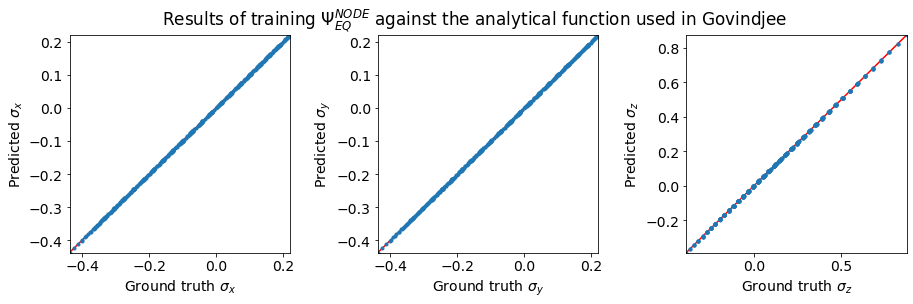

In [11]:
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, Psi_eq_params)
sigma_gt = sigma_neoHook_vmap(lm1, lm2, lm3, gov_Psi_eq_params) #since I am using the same MM for both EQ and NEQ
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{EQ}^{NODE}$ against the analytical function used in Govindjee"
plot45(gts, prs, labels, title)

## 2.2 $\Psi_{NEQ}$

In [12]:
# Initialize parameters
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
K, mu = gov_Psi_neq_params
Psi_neq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias, K)
Psi_neq_norm = None

# Generate outputs
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],gov_Psi_neq_params)

opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Psi_neq_params)
Psi_neq_params, train_loss, val_loss = train(lmb, sigma_gt, Psi_neq_norm, False, opt_state, key, Psi_loss, nIter = 200000, batch_size=10, print_freq=10000)

with open('saved/brain_BG_Psi_neq_params.npy', 'wb') as f:
    pickle.dump(Psi_neq_params, f)

it 0, train loss = 1.556842e+01
it 10000, train loss = 2.350093e-03
it 20000, train loss = 3.989366e-04
it 30000, train loss = 7.630326e-05
it 40000, train loss = 4.916623e-05
it 50000, train loss = 2.962055e-05
it 60000, train loss = 2.818752e-05
it 70000, train loss = 9.068946e-06
it 80000, train loss = 4.800819e-06
it 90000, train loss = 2.510942e-06
it 100000, train loss = 1.281901e-06
it 110000, train loss = 1.814238e-06
it 120000, train loss = 3.300354e-07
it 130000, train loss = 2.143326e-07
it 140000, train loss = 2.329501e-06
it 150000, train loss = 4.270444e-08
it 160000, train loss = 2.223926e-08
it 170000, train loss = 1.344700e-08
it 180000, train loss = 6.815784e-09
it 190000, train loss = 4.155901e-09
it 200000, train loss = 2.681233e-09


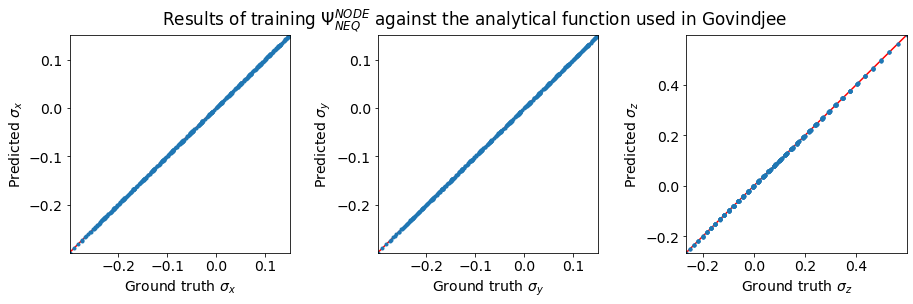

In [13]:
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, Psi_neq_params)
sigma_gt = sigma_neoHook_vmap(lm1, lm2, lm3, gov_Psi_neq_params)
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{NEQ}^{NODE}$ against the analytical function used in Govindjee"
plot45(gts, prs, labels, title)

# 3. Train $\Phi^{NODE}$ with $\Phi^{Govindjee}$

In [14]:
with open('saved/brain_BG_gov_params.npy', 'rb') as f:
    gov_params = pickle.load(f)
gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params = gov_params
eta_D, eta_V = gov_Phi_params

In [15]:
# Generate training data
# Input data and normalization factors
taui = onp.mgrid[-1.0:1.0:10j, -1.0:1.0:10j, -1.0:1.0:10j]
taui = taui.reshape([3,-1]).transpose()
taui = -onp.sort(-taui)

tau1 = taui[:,0]
tau2 = taui[:,1]
tau3 = taui[:,2]
I12     = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
I12m3I2 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3

inp_std3 = onp.std(tau1 + tau2 + tau3)
inp_std4 = onp.std(I12)
inp_std5 = onp.std(I12m3I2)
inp_stds = (inp_std3, inp_std4, inp_std5)

out_std3 = 1.0
out_std4 = 1/9/175000
out_std5 = 1/3/1360
out_stds = (out_std3, out_std4, out_std5)
Phi_norm = (inp_stds, out_stds)

# Output data
dphidtaui = onp.array(dPhi_gov_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)).transpose()

# Initialize NN weights
layers = [1,2,3,1]
NODE3_params = init_params_positivebias(layers, key)
NODE4_params = init_params_positivebias(layers, key)
NODE5_params = init_params_positivebias(layers, key)
Phi_params = [NODE3_params, NODE4_params, NODE5_params]

In [16]:
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Phi_params)
Phi_params, train_loss, val_loss = train(taui, dphidtaui, Phi_norm, False, opt_state, key, Phi_loss, nIter = 200000, batch_size=100, print_freq=10000)

with open('saved/brain_BG_Phi_params.npy', 'wb') as f:
    pickle.dump(Phi_params, f)
with open('saved/brain_BG_Phi_norm_w.npy', 'wb') as f:
    pickle.dump(Phi_norm, f)

it 0, train loss = 7.446026e+00
it 10000, train loss = 6.135306e-02
it 20000, train loss = 3.614253e-03
it 30000, train loss = 1.048696e-03
it 40000, train loss = 2.044795e-05
it 50000, train loss = 2.874948e-06
it 60000, train loss = 2.625073e-06
it 70000, train loss = 2.590381e-06
it 80000, train loss = 2.563073e-06
it 90000, train loss = 2.512664e-06
it 100000, train loss = 2.388306e-06
it 110000, train loss = 2.063160e-06
it 120000, train loss = 1.306114e-06
it 130000, train loss = 4.496829e-07
it 140000, train loss = 4.310531e-07
it 150000, train loss = 4.309287e-07
it 160000, train loss = 4.311487e-07
it 170000, train loss = 4.307844e-07
it 180000, train loss = 4.307691e-07
it 190000, train loss = 4.311044e-07
it 200000, train loss = 4.306939e-07


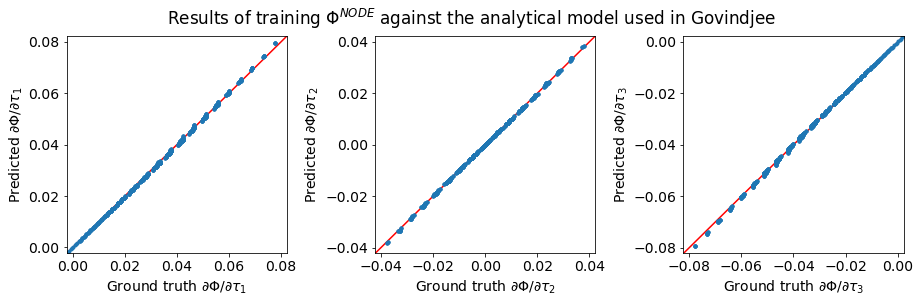

In [17]:
prs = dPhi_vmap([taui[:,0], taui[:,1], taui[:,2]], Phi_params, Phi_norm)
gts = dPhi_gov_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)

labels = ['$\partial \Phi / \partial \\tau_1$', '$\partial \Phi / \partial \\tau_2$', '$\partial \Phi / \partial \\tau_3$']
title = r"Results of training $\Phi^{NODE}$ against the analytical model used in Govindjee"
plot45(gts, prs, labels, title)

# 4. Test

In [3]:
#Load the pre-trained parameters
with open('saved/brain_BG_Psi_eq_params.npy', 'rb') as f:
    Psi_eq_params = pickle.load(f)
with open('saved/brain_BG_Psi_neq_params.npy', 'rb') as f:
    Psi_neq_params = pickle.load(f)
with open('saved/brain_BG_Phi_params.npy', 'rb') as f:
    Phi_params = pickle.load(f)
with open('saved/brain_BG_Phi_norm_w.npy', 'rb') as f:
    Phi_norm = pickle.load(f)
params = (Psi_eq_params, Psi_neq_params, Phi_params)
norm = (None, None, Phi_norm)

with open('saved/brain_BG_gov_params.npy', 'rb') as f:
    gov_params = pickle.load(f)

with open('training_data/Brain/Average/C1/Comp relaxation/BG.npy','rb') as f:
    time_2, sgm_x_2 = np.load(f).T
time_2 = time_2[::2]
sgm_x_2 = sgm_x_2[::2]

load_rate = 0.03 #loading rate
lm_peak = 0.9
lm_1 = np.linspace(1.0,0.9,10)
lm_2 = np.ones_like(time_2)*lm_peak
lmb_x = np.hstack([lm_1,lm_2])

t_peak = (1.0-lm_peak)/load_rate
print('Reach peak in '+str(t_peak)+' s')
time_1 = np.linspace(0,t_peak,lm_1.shape[0])
time = np.hstack([time_1, time_2+t_peak])

sgm_x_1 = np.linspace(0,sgm_x_2[0],lm_1.shape[0])
sgm_x = np.hstack([sgm_x_1, sgm_x_2])

time = np.expand_dims(time,0)
lmb_x = np.expand_dims(lmb_x,0)
sgm_x = np.expand_dims(sgm_x,0)

inp = np.array([time, lmb_x]).transpose([1,0,2])
out = sgm_x

Reach peak in 3.3333333333333326 s


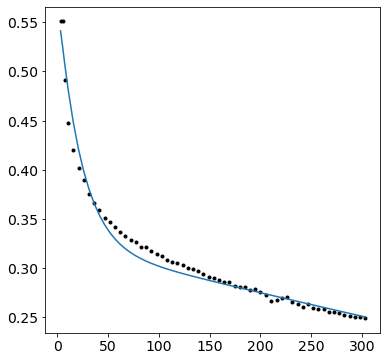

In [4]:
fig, ax = plt.subplots(figsize=(6,6))

sig_NN, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = uniaxial_relax(params, norm, True, time[0], lmb_x[0], dt0=0.1)

ax.plot(time[0,9:], sgm_x[0,9:], 'k.')
ax.plot(time[0,9:],-sig_NN[9:,0,0])

## 5. Retrain

2022-12-20 08:40:18.547939: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_step.59
********************************
2022-12-20 09:20:17.406919: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_uniaxial_relax.61
********************************


it 0, train loss = 3.420157e-04
it 100, train loss = 8.646148e-05
it 200, train loss = 8.303886e-05
it 300, train loss = 7.516320e-05
it 400, train loss = 7.205768e-05
it 500, train loss = 6.936544e-05
it 600, train loss = 6.697470e-05
it 700, train loss = 6.484812e-05
it 800, train loss = 6.291813e-05
it 900, train loss = 6.167386e-05
it 1000, train loss = 5.666126e-05
it 1100, train loss = 5.675517e-05
it 1200, train loss = 5.364427e-05
it 1300, train loss = 5.185608e-05
it 1400, train loss = 5.204471e-05
it 1500, train loss = 4.953653e-05
it 1600, train loss = 4.786412e-05
it 1700, train loss = 4.777217e-05
it 1800, train loss = 4.582373e-05
it 1900, train loss = 4.481923e-05
it 2000, train loss = 4.389619e-05
it 2100, train loss = 4.302513e-05
it 2200, train loss = 4.220913e-05
it 2300, train loss = 4.166314e-05
it 2400, train loss = 4.228073e-05
it 2500, train loss = 4.419401e-05
it 2600, train loss = 4.120510e-05
it 2700, train loss = 3.978242e-05
it 2800, train loss = 3.899608e-

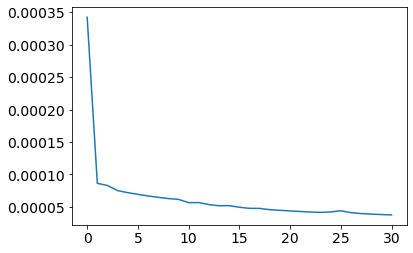

In [5]:
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(params)

params, train_loss, val_loss = train(inp, out, norm, True, opt_state, key, uniaxial_relax_batch_loss, nIter = 3000, batch_size=1, print_freq=100)

with open('saved/brain_BG_params_retrained.npy', 'wb') as f:
    pickle.dump(params, f)

plt.plot(train_loss)

## 6. Final test

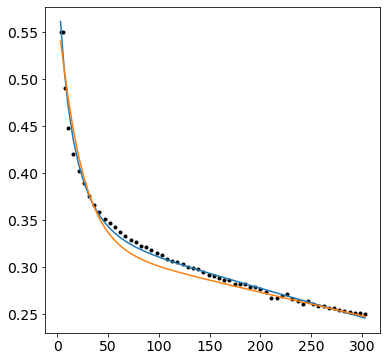

: 

In [6]:
with open('saved/brain_BG_params_retrained.npy', 'rb') as f:
    params = pickle.load(f)
with open('saved/brain_BG_Phi_norm_w.npy', 'rb') as f:
    Phi_norm = pickle.load(f)

with open('saved/brain_BG_gov_params.npy', 'rb') as f:
    gov_params = pickle.load(f)
norm = (None, None, Phi_norm)

fig, ax = plt.subplots(figsize=(6,6))

sig_NN, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = uniaxial_relax(params, norm, True, time[0], lmb_x[0], dt0=0.1)
sig_RG, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = uniaxial_relax(gov_params, norm, False, time[0], lmb_x[0], dt0=0.1)

ax.plot(time[0,9:], sgm_x[0,9:], 'k.')
ax.plot(time[0,9:],-sig_NN[9:,0,0])
ax.plot(time[0,9:],-sig_RG[9:,0,0])

data = np.array([time[0,9:], sgm_x[0,9:], -sig_NN[9:,0,0], -sig_RG[9:,0,0]])
columns = ['x', 'y_gt', 'y_nn', 'y_rg']
df = pd.DataFrame(data.T, columns=columns)
df.to_csv('tikz_data/fig_brain/fig_brain_BG.csv', index=False, sep=' ')

In [12]:
nn = []
rg = []
for mat in ['BG', 'CC', 'CR', 'CO']:
    print(mat)
    data = pd.read_csv('tikz_data/fig_brain/fig_brain_'+mat+'.csv', sep=' ')
    mae_RG = onp.mean(onp.abs(data.y_rg-data.y_gt))
    mae_NN = onp.mean(onp.abs(data.y_nn-data.y_gt))
    nn.append(mae_NN)
    rg.append(mae_RG)
    print('RG MAE = ', mae_RG)
    print('NODE MAE = ', mae_NN)
nn = onp.array(nn)
rg = onp.array(rg)

BG
RG MAE =  0.007574180437312786
NODE MAE =  0.0038086281417292716
CC
RG MAE =  0.008810444511013794
NODE MAE =  0.006919819279914097
CR
RG MAE =  0.016850456904027707
NODE MAE =  0.007826999226644194
CO
RG MAE =  0.02008902031695516
NODE MAE =  0.010910244806763787


In [14]:
mae_nn = onp.mean(nn)
mae_rg = onp.mean(rg)
print(mae_nn, mae_rg, mae_rg/mae_nn)

0.007366422863762837 0.01333102554232736 1.8097013691551436
